In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from PIL import Image
from sklearn.svm import SVC
import os   



data=[]
base_dir='train'
folders=os.listdir('train')
for folder in folders:
    images=os.listdir(os.path.join(base_dir,folder))
    for image in images: 
        data.append(
            {
                'image path': os.path.join(base_dir,folder,image),
                'label': folder
            }
        )
    train_data=pd.DataFrame(data)
train_data.head()




data=[]
base_dir='val'
folders=os.listdir('val')
for folder in folders:
    images=os.listdir(os.path.join(base_dir,folder))
    for image in images: 
        data.append(
            {
                'image path': os.path.join(base_dir,folder,image),
                'label': folder
            }
        )
val_data=pd.DataFrame(data)
val_data.head()

,image path,label
0,val\cactus\image_01241.jpg,cactus
1,val\cactus\image_01593.jpg,cactus
2,val\cactus\image_01634.jpg,cactus
3,val\cactus\image_03932.jpg,cactus
4,val\cactus\image_04346.jpg,cactus


In [3]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage import exposure
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Preprocessing function
def preprocess_image(image):
    # Resize
    image = cv2.resize(image, (64, 64))
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Normalize
    normalized = gray / 255.0
    # Gaussian blur
    blurred = cv2.GaussianBlur(normalized, (3, 3), 0)  # 3×3 grid
    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply((blurred * 255).astype(np.uint8))
    return enhanced


def segment_ball(image):
    # Adaptive thresholding
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)    
    kernel = np.ones((3, 3), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    # Find contours
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        # Expand bounding box with margin
        margin = 5
        x = max(0, x - margin)
        y = max(0, y - margin)
        w = min(image.shape[1] - x, w + 2*margin)
        h = min(image.shape[0] - y, h + 2*margin)
        segmented = image[y:y+h, x:x+w]
        return segmented, (x, y, w, h)
    return image, (0, 0, image.shape[1], image.shape[0])  # Fallback
# Segmentation function
# def segment_ball(image):
#     # Adaptive thresholding for varying lighting
#     _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
#     # Morphological operations
#     kernel = np.ones((5, 5), np.uint8)
#     morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel,iterations=3)

#     # Find contours
#     contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     if contours:
#         largest_contour = max(contours, key=cv2.contourArea)
#         x, y, w, h = cv2.boundingRect(largest_contour)
#         # Expand the bounding box slightly to capture full ball
#         margin = 5
#         x = max(0, x - margin)
#         y = max(0, y - margin)
#         w = min(image.shape[1] - x, w + 2 * margin)
#         h = min(image.shape[0] - y, h + 2 * margin)
#         segmented_ball = image[y:y+h, x:x+w]
#         return segmented_ball
#     return image

# Ensure fixed size for HOG
def ensure_fixed_size(image, fixed_size=(64, 64)):
    """
    Resize the image to a fixed size required for HOG.
    """
    return cv2.resize(image, fixed_size)

# HOG feature extraction function
def extract_hog_features(images):
    hog_features_list = []
    hog_images_list = []
    
    for img in images:
        # Convert image to grayscale if it's RGB
        if len(img.shape) == 3:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img_gray = img
        
        # Ensure fixed size for HOG
        img_gray = ensure_fixed_size(img_gray)
        
        fd, hog_image = hog(img_gray, pixels_per_cell=(4, 4),
                            cells_per_block=(2, 2), visualize=True)
        
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        
        # Append results
        hog_features_list.append(fd)
        hog_images_list.append(hog_image_rescaled)
    
    return hog_features_list, hog_images_list

# Load data function


In [4]:
def load_data(tr_df, ts_df):
    # Load images from file paths
    X_train = [cv2.imread(path) for path in tr_df["image path"]]
    X_test = [cv2.imread(path) for path in ts_df["image path"]]
    y_train = tr_df["label"]
    y_test = ts_df["label"]
    return X_train, X_test, y_train, y_test

# Load data
X_train_raw, X_test_raw, y_train, y_test = load_data(train_data, val_data)

# Preprocess and segment images
X_train_preprocessed = [preprocess_image(img) for img in X_train_raw]
X_test_preprocessed = [preprocess_image(img) for img in X_test_raw]

# Process training images with bounding boxes
X_train_segmented = []
train_bboxes = []  # Store training bounding boxes
for img in X_train_preprocessed:
    segmented, bbox = segment_ball(img)  # Unpack both returns
    X_train_segmented.append(segmented)
    train_bboxes.append(bbox)

# Process test images (as you already have)
X_test_segmented = []
test_bboxes = []
for img in X_test_preprocessed:
    segmented, bbox = segment_ball(img)
    X_test_segmented.append(segmented)
    test_bboxes.append(bbox)

# Extract HOG features
X_train_hog_features, X_train_hog_image = extract_hog_features(X_train_segmented)
X_test_hog_features, X_test_hog_image = extract_hog_features(X_test_segmented)

# Flatten HOG features
X_train_hog_flat = np.array([features.flatten() for features in X_train_hog_features])
X_test_hog_flat = np.array([features.flatten() for features in X_test_hog_features])

# Apply MinMax scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_hog_flat)
X_test_scaled = scaler.transform(X_test_hog_flat)

# Apply PCA
pca = PCA(n_components=0.95)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train SVC model
svc =  SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced',random_state=42)
svc.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred = svc.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 47.08%


In [5]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      cactus       0.45      0.68      0.54        96
        fern       0.63      0.25      0.36        96
        rose       0.49      0.50      0.49        96
   sunflower       0.37      0.62      0.47        96
       tulip       0.74      0.30      0.43        96

    accuracy                           0.47       480
   macro avg       0.54      0.47      0.46       480
weighted avg       0.54      0.47      0.46       480



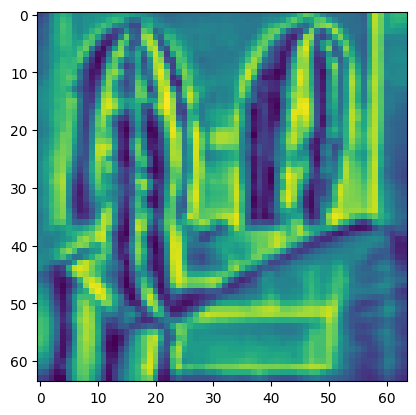

In [6]:
#plt the frist img out from the hog list
plt.imshow(X_test_preprocessed[0])
plt.show()

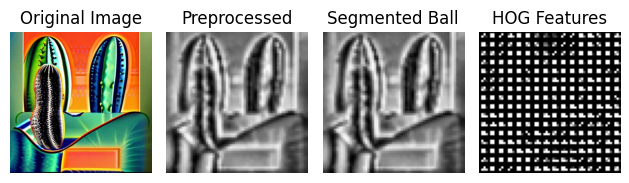

In [7]:
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(X_test_raw[0], cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Preprocessed image
plt.subplot(1, 4, 2)
plt.imshow(X_test_preprocessed[0], cmap='gray')
plt.title("Preprocessed")
plt.axis('off')

# Segmented ball
plt.subplot(1, 4, 3)
plt.imshow(X_test_segmented[0], cmap='gray')
plt.title("Segmented Ball")
plt.axis('off')

# HOG visualization
plt.subplot(1, 4, 4)
plt.imshow(X_test_hog_image[0], cmap='gray')
plt.title("HOG Features")
plt.axis('off')

plt.tight_layout()
plt.show()

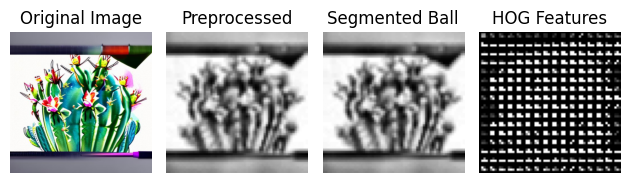

In [8]:
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(X_train_raw[0], cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Preprocessed image
plt.subplot(1, 4, 2)
plt.imshow(X_train_preprocessed[0], cmap='gray')
plt.title("Preprocessed")
plt.axis('off')

# Segmented ball
plt.subplot(1, 4, 3)
plt.imshow(X_train_segmented[0], cmap='gray')
plt.title("Segmented Ball")
plt.axis('off')

# HOG visualization
plt.subplot(1, 4, 4)
plt.imshow(X_train_hog_image[0], cmap='gray')
plt.title("HOG Features")
plt.axis('off')

plt.tight_layout()
plt.show()

(-0.5, 63.5, 63.5, -0.5)

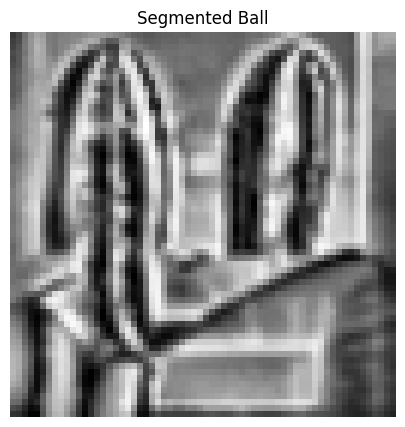

In [9]:
plt.figure(figsize=(10,5))
plt.imshow(X_test_segmented[0], cmap='gray')
plt.title("Segmented Ball")
plt.axis('off')

In [10]:



prediction = svc.predict(X_test_pca)[0]
print(prediction)    



cactus


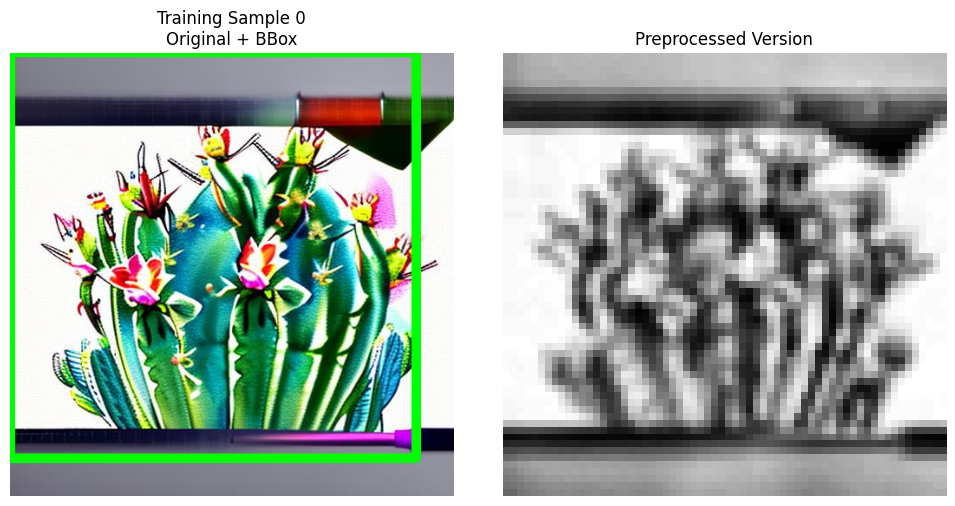

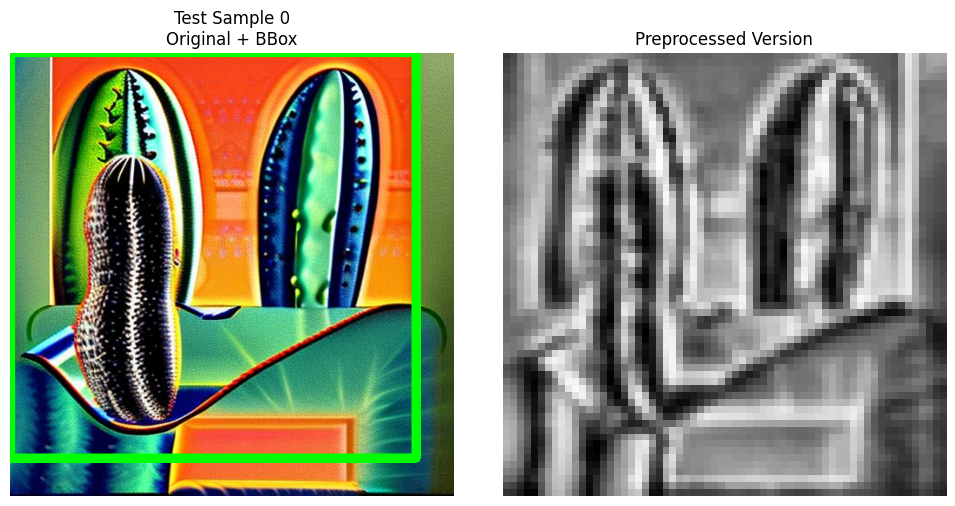

In [29]:
X_train_segmented = []
train_bboxes = []
for img in X_train_preprocessed:
    seg, bbox = segment_ball(img)
    X_train_segmented.append(seg)
    train_bboxes.append(bbox)

X_test_segmented = []
test_bboxes = []
for img in X_test_preprocessed:
    seg, bbox = segment_ball(img)
    X_test_segmented.append(seg)
    test_bboxes.append(bbox)

def plot_sample(data_type, index, bboxes):
    if data_type == "train":
        img = X_train_raw[index]
        preprocessed = X_train_preprocessed[index]
        bbox = bboxes[index]
        title = "Training Sample"
    else:
        img = X_test_raw[index]
        preprocessed = X_test_preprocessed[index]
        bbox = bboxes[index]
        title = "Test Sample"
    
    # Convert coordinates back to original size
    h_orig, w_orig = img.shape[:2]
    x = int(bbox[0] * w_orig / 64)
    y = int(bbox[1] * h_orig / 64)
    w = int(bbox[2] * w_orig / 70)
    h = int(bbox[3] * h_orig / 70)
    
    # Draw bounding box
    display_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(display_img, (x, y), (x+w, y+h), (0,255,0), 10)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(display_img)
    plt.title(f"{title} {index}\nOriginal + BBox")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed, cmap='gray')
    plt.title("Preprocessed Version")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_sample("train", 0, train_bboxes)  # First training sample
plot_sample("test", 0, test_bboxes)    # First test sample

In [35]:
#save model

import pickle
pickle.dump(svc, open('model.pkl', 'wb'))